In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM
from tqdm import tqdm

# reload utils
import importlib
importlib.reload(utils)


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.family'] = 'Calibri'

path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1,2,3, 4, 5, 6]

num_trained_seq = 1

total_sub_num = 20
num_sessions = 3
num_blocks_per_session = 4

num_baseline_blocks = 1
num_trials_per_block = 40

percentile_low = 45;	# Lower percentile for ETs
percentile_high = 80;	# Upper percentile for ETs
percentile_low_super = 10;	# Lower percentile for ETs



In [44]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 7.62, "1.5col": 11.6, "2col": 16.5}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    rcParams["font.size"] = 10  # General font size
    # rcParams["font.size"] = 20  # General font size
    rcParams["axes.titlesize"] = 12  # Figure title
    # rcParams["axes.titlesize"] = 26  # Figure title
    rcParams["axes.labelsize"] = 9  # Axis main label
    # rcParams["axes.labelsize"] = 22  # Axis main label
    rcParams["xtick.labelsize"] = 7  # Tick labels
    # rcParams["xtick.labelsize"] = 16  # Tick labels
    rcParams["ytick.labelsize"] = 7
    # rcParams["ytick.labelsize"] = 16
    rcParams["legend.fontsize"] = 8  # Legend entries
    # rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    rcParams["axes.linewidth"] = 0.75
    # rcParams["axes.linewidth"] = 1.5

    # rcParams["lines.linewidth"] = 3
    
    rcParams["xtick.major.width"] = 0.75
    # rcParams["xtick.major.width"] = 1.5
    rcParams["ytick.major.width"] = 0.75
    # rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")

sns.set_palette("colorblind")


In [45]:
subjs = pd.read_csv(utils.path_misc+'subjs.csv', sep = '\t')

In [46]:
subjs

BN  TN  SubNum  hand  isTrain      cue  press1  press2  press3  press4  \
0      1   1       1     2        0  1243514       1       2       4       3   
1      1   2       1     2        0  1532324       1       5       3       2   
2      1   3       1     2        0  5142423       5       1       4       2   
3      1   4       1     2        0  5253431       5       2       5       3   
4      1   5       1     2        0  4342531       4       3       4       2   
...   ..  ..     ...   ...      ...      ...     ...     ...     ...     ...   
4075  17  36       6     2        1  5312141       5       3       1       2   
4076  17  37       6     2        1  5312141       5       3       1       2   
4077  17  38       6     2        1  5312141       5       3       1       2   
4078  17  39       6     2        1  5312141       5       3       1       2   
4079  17  40       6     2        1  5312141       5       3       1       2   

      ...  useMetronome  isCross  crossTime           globalStartTime  IPI1  \
0     ...             0        0          0  Tue Jun 03 18:11:57 2025   200   
1     ...             0        0          0  Tue Jun 03 18:12:04 2025   340   
2     ...             0        0          0  Tue Jun 03 18:12:10 2025   240   
3     ...             0        0          0  Tue Jun 03 18:12:18 2025   365   
4     ...             0        0          0  Tue Jun 03 18:12:25 2025   260   
...   ...           ...      ...        ...                       ...   ...   
4075  ...             0        0          0  Thu Jun 19 18:24:21 2025   125   
4076  ...             0        0          0  Thu Jun 19 18:24:26 2025   150   
4077  ...             0        0          0  Thu Jun 19 18:24:30 2025   130   
4078  ...             0        0          0  Thu Jun 19 18:24:35 2025   110   
4079  ...             0        0          0  Thu Jun 19 18:24:41 2025   245   

      IPI2  IPI3  IPI4  IPI5  IPI6  
0      330   430   595   235   450  
1      645   330   600   330   360  
2      405   455   820   250  1290  
3      495   665   395   445   310  
4      235   655   315  1000   285  
...    ...   ...   ...   ...   ...  
4075   195   145   185    95   160  
4076   160    10   250    15   135  
4077   185   635   195    65   190  
4078   190    60  1035   155   170  
4079  1175   165   660   220   150  

[4080 rows x 61 columns]

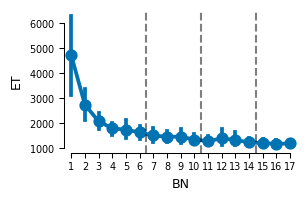

In [47]:
subjs_correct = utils.remove_error_trials(subjs) ###Removing error trials
subjs_grouped = subjs_correct.groupby(['SubNum', 'BN']).agg({
    'ET': 'median'
}).reset_index()
sns.pointplot(data = subjs_grouped, x = 'BN', y = 'ET')
for day_change in [5.5, 9.5, 13.5]:
    plt.axvline(day_change, color = 'k', linestyle = '--', alpha = 0.5)
sns.despine(trim = True)


In [56]:
subjs.columns

Index(['BN', 'TN', 'SubNum', 'hand', 'isTrain', 'cue', 'press1', 'press2',
       'press3', 'press4', 'press5', 'press6', 'press7', 'RT', 'ET', 'MT',
       'isError', 'timingError', 'points', 'zone', 'response1', 'response2',
       'response3', 'response4', 'response5', 'response6', 'response7',
       'handPressed1', 'handPressed2', 'handPressed3', 'handPressed4',
       'handPressed5', 'handPressed6', 'handPressed7', 'pressTime1',
       'pressTime2', 'pressTime3', 'pressTime4', 'pressTime5', 'pressTime6',
       'pressTime7', 'timeThreshold', 'timeThresholdSuper',
       'estimatedPercentileHigh', 'estimatedPercentileLow',
       'estimatedPercentileLowSuper', 'startTime', 'startTimeReal', 'trialDur',
       'startTR', 'startTRtime', 'useMetronome', 'isCross', 'crossTime',
       'globalStartTime', 'IPI1', 'IPI2', 'IPI3', 'IPI4', 'IPI5', 'IPI6'],
      dtype='object')

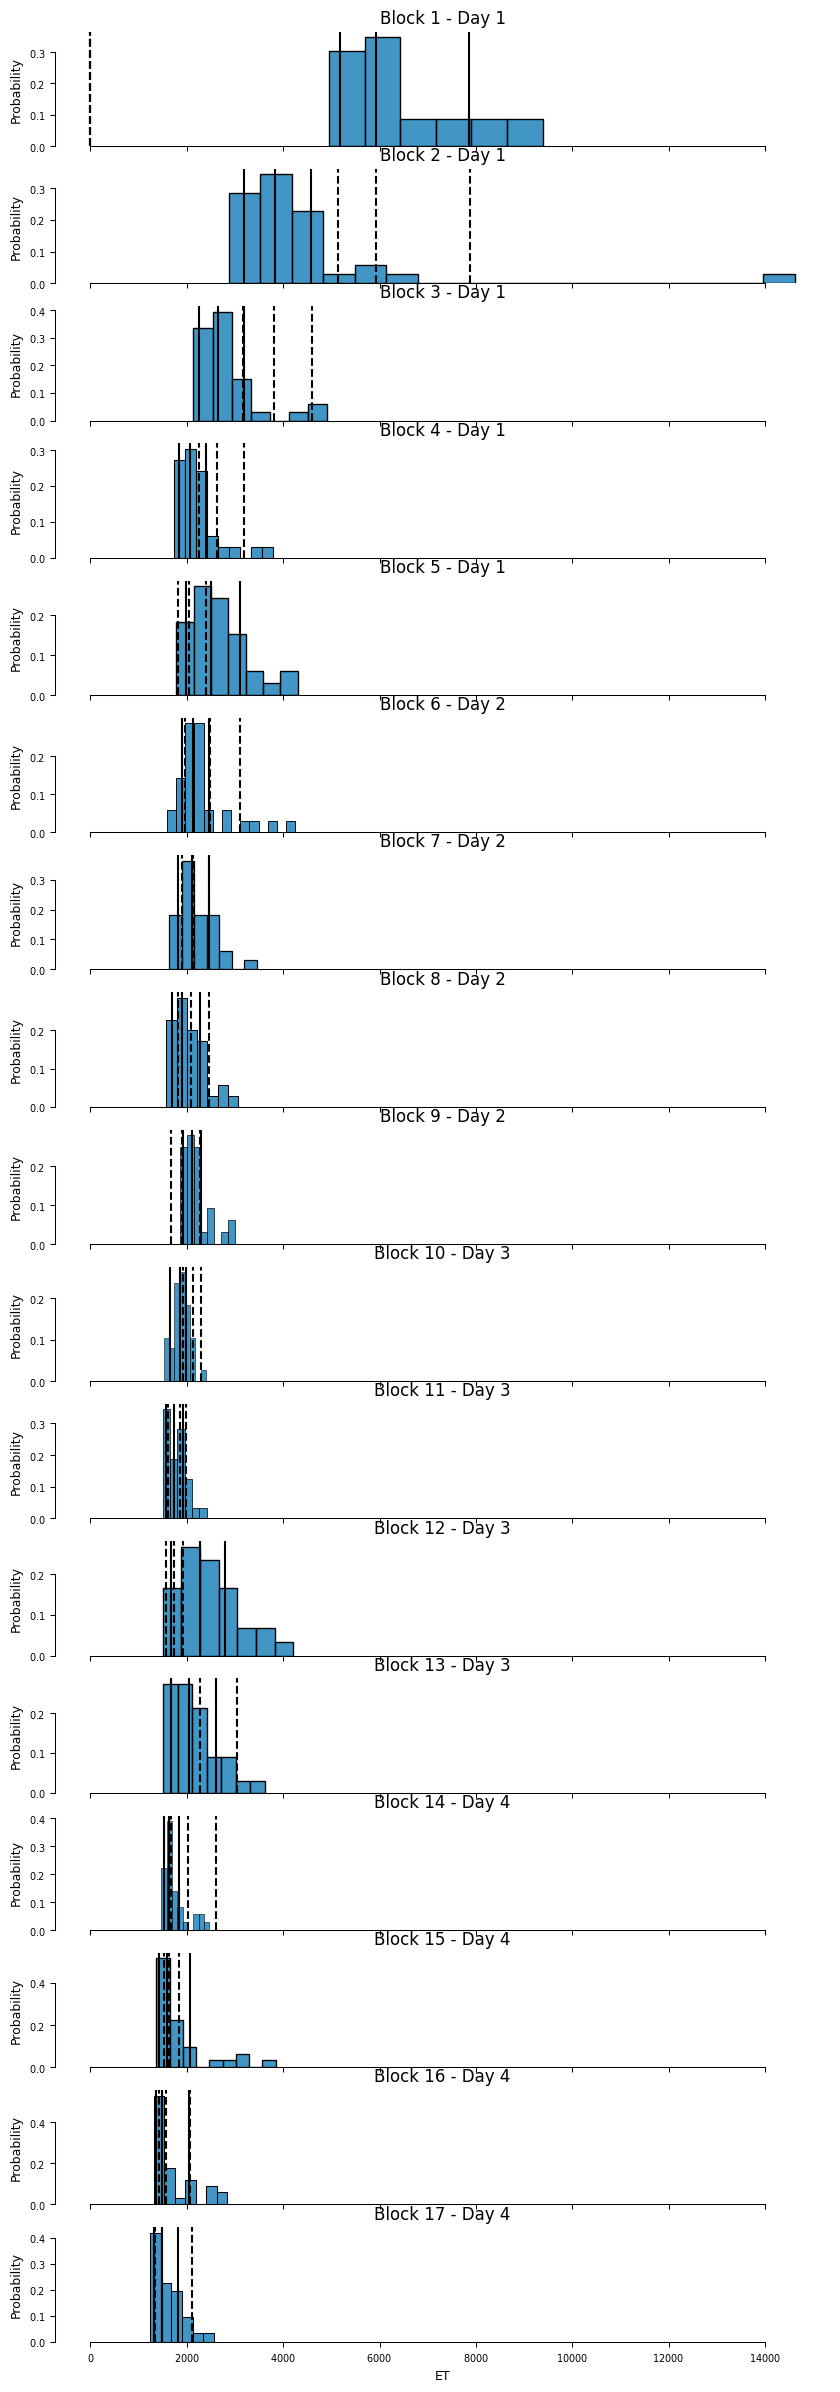

In [63]:
fig, axs = plt.subplots(len(subjs['BN'].unique()),1, figsize=(10, 30), sharex=True)
selected_sub = subjs[subjs['SubNum'] == 6] ###Selecting one subject
day_changes = [5.5, 9.5, 13.5, 17.5] #Day change points

selected_sub = utils.remove_error_trials(selected_sub) ###Removing error trials for the selected subject
for bn, block_data in selected_sub.groupby('BN'):
    sns.histplot(data = block_data, x = 'ET', ax = axs[bn-1], stat = 'probability')
    axs[bn-1].axvline(block_data['estimatedPercentileHigh'].values[0], linestyle = '--', color = 'black')
    axs[bn-1].axvline(block_data['estimatedPercentileLow'].values[0], linestyle = '--', color = 'black')
    axs[bn-1].axvline(block_data['estimatedPercentileLowSuper'].values[0],linestyle = '--', color = 'black')

    axs[bn-1].axvline(np.percentile(block_data['ET'], percentile_low_super), linestyle = '-', color = 'black')
    axs[bn-1].axvline(np.percentile(block_data['ET'], percentile_low), linestyle = '-', color = 'black')
    axs[bn-1].axvline(np.percentile(block_data['ET'], percentile_high), linestyle = '-', color = 'black')


    
    for day, day_change in enumerate(day_changes):
        if bn < day_change:
            break


    

    axs[bn-1].set_title(f'Block {bn} - Day {day+1}')

sns.despine(trim = True)

# Force Analysis

In [64]:
subjs = pd.read_csv(utils.path_misc+'subjs.csv', sep = '\t')

In [65]:
# exclude first block 
subjs = subjs[subjs['BN'] > 1]
rank_df = pd.DataFrame(index = subjs.index)
for subnum, data in subjs.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['N'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'N'] = data['N'].astype('int')
        

subjs['N'] = rank_df['N'].astype('int')
subjs = subjs[subjs['isCross'] == 0]

In [66]:

processed_forces = pd.read_csv(utils.path_misc+'processed_forces.csv', sep = '\t')
# convert force_vector to numpy array
processed_forces['force_vector'] = processed_forces['force_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))


In [67]:
processed_forces.columns

Index(['SubNum', 'BN', 'TN', 'points', 'zone', 'isError', 'RT', 'ET', 'N',
       'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9',
       'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16',
       'force_vector', 'day', 'day_change', 'block_change'],
      dtype='object')

100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


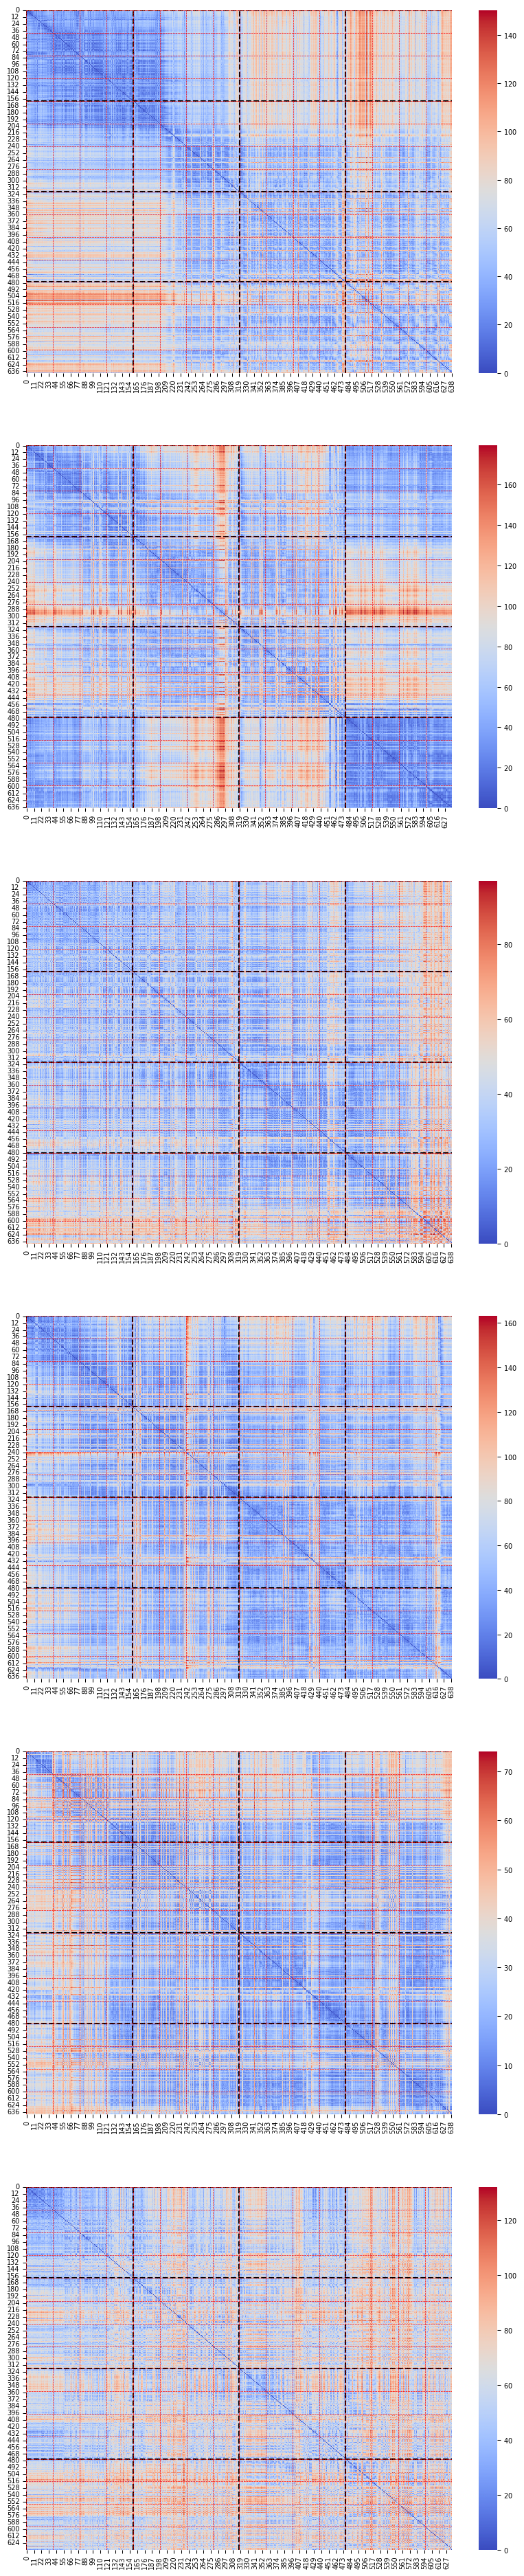

In [69]:
n_subjs = len(processed_forces['SubNum'].unique())
fig, axs = plt.subplots(n_subjs, figsize=(10, n_subjs * 8))
n_dims = 16
for subind, subdata in tqdm(processed_forces.groupby('SubNum')):
    # compute euclidean distance of all force vectors from each other
    force_vectors = subdata[[f'PC_{i+1}' for i in range(n_dims)]].to_numpy()
    euclidean_distances = np.linalg.norm(force_vectors[:, np.newaxis] - force_vectors, axis=2)


    sns.heatmap(euclidean_distances, cmap='coolwarm', annot=False, cbar=True, ax=axs[subind-1])

    # plotting day changes on the heatmap
    day_changes = subdata['day_change'].values
    for i in range(len(day_changes)):
        if day_changes[i] == 1:
            axs[subind-1].axvline(i, color='black', linestyle='--')
            axs[subind-1].axhline(i, color='black', linestyle='--')

    # plotting block changes on the heatmap
    block_changes = subdata['block_change'].values
    for i in range(len(block_changes)):
        if block_changes[i] == 1:
            axs[subind-1].axvline(i, color='red', linestyle='--', linewidth=0.5)
            axs[subind-1].axhline(i, color='red', linestyle='--',  linewidth=0.5)


    
    
    


    

# Modulation of Distance based on Reward

In [104]:
distances = []
for subind, subdata in processed_forces.groupby('SubNum'):
    zone_two_data = subdata[subdata['zone'] == 2]
    for point, pointdata in zone_two_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute the euclidean distance between the force vectors of the two trials
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                euclidean_distance = np.linalg.norm(force_vector_1 - force_vector_2)
                distances.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'distance': euclidean_distance
                })

    zone_three_data = subdata[subdata['zone'] == 3]
    for point, pointdata in zone_three_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute the euclidean distance between the force vectors of the two trials
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                euclidean_distance = np.linalg.norm(force_vector_1 - force_vector_2)
                distances.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'distance': euclidean_distance
                })
        

distances = pd.DataFrame(distances)
        
distances['count'] = 1

In [105]:
# calculate number of points in each zone for each subject
zone_counts = processed_forces.groupby(['SubNum', 'zone']).size().reset_index(name='count')
zone_counts

SubNum  zone  count
0        1     0    102
1        1     1    154
2        1     2    153
3        1     3    115
4        1     4    115
5        2     0    128
6        2     1    125
7        2     2    162
8        2     3    143
9        2     4     80
10       3     0     81
11       3     1    215
12       3     2    166
13       3     3     99
14       3     4     79
15       4     0     96
16       4     1    211
17       4     2    132
18       4     3    111
19       4     4     90
20       5     0     47
21       5     1    179
22       5     2    197
23       5     3    108
24       5     4    109
25       6     0    102
26       6     1    180
27       6     2    143
28       6     3    111
29       6     4    100

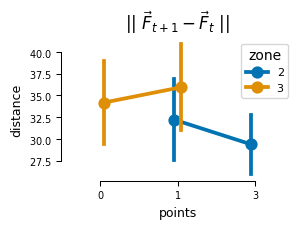

Zone: 2
TtestResult(statistic=1.6759075771533398, pvalue=0.1546049824727383, df=5)
Zone: 3
TtestResult(statistic=-1.428331657769322, pvalue=0.2125642986491519, df=5)


In [106]:
grouped_distances = distances.groupby(['SubNum', 'points', 'zone']).agg({'distance': 'mean',
                                                                         'count': 'count'}).reset_index()
grouped_distances

sns.pointplot(data=grouped_distances, x='points', y='distance', hue='zone', palette='colorblind', dodge=0.1, errorbar='se')
sns.despine(trim=True)
plt.title(r'|| $\vec{F}_{t+1} - \vec{F}_{t}$ ||')
plt.show()

for group_data in grouped_distances.groupby('zone'):
    points = group_data[1]['points'].unique()
    print(f"Zone: {group_data[0]}")
    print(stats.ttest_rel(group_data[1][group_data[1]['points'] == points[0]]['distance'],
                    group_data[1][group_data[1]['points'] == points[1]]['distance']))

# Modulation of cos angel on innovation based on Reward

In [85]:
cosines = []
for subind, subdata in processed_forces.groupby('SubNum'):
    zone_two_data = subdata[subdata['zone'] == 2]
    for point, pointdata in zone_two_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            prev_trial = subdata[subdata['N'] == N - 1]
            if not next_trial.empty and not prev_trial.empty:
                next_row = next_trial.iloc[0]
                prev_row = prev_trial.iloc[0]
                # compute cosine similarity between difference
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                force_vector_3 = prev_row['force_vector']
                cosine_similarity = np.dot(force_vector_1 - force_vector_3, force_vector_2 - force_vector_1)/ \
                (np.linalg.norm(force_vector_1 - force_vector_3) * np.linalg.norm(force_vector_2 - force_vector_1)) 
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })



    zone_three_data = subdata[subdata['zone'] == 3]
    for point, pointdata in zone_three_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            prev_trial = subdata[subdata['N'] == N - 1]
            if not next_trial.empty and not prev_trial.empty:
                next_row = next_trial.iloc[0]
                prev_row = prev_trial.iloc[0]
                # compute cosine similarity between difference
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                force_vector_3 = prev_row['force_vector']
                cosine_similarity = np.dot(force_vector_1 - force_vector_3, force_vector_2 - force_vector_1)/ \
                (np.linalg.norm(force_vector_1 - force_vector_3) * np.linalg.norm(force_vector_2 - force_vector_1)) 
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })
        

cosines = pd.DataFrame(cosines)
        
cosines['count'] = 1

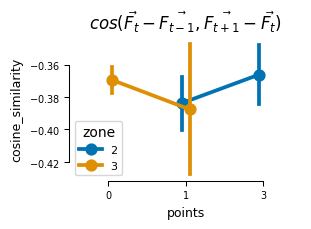

In [88]:
grouped_cosines = cosines.groupby(['SubNum', 'points', 'zone']).agg({'cosine_similarity': 'mean',
                                                                         'count': 'count'}).reset_index()
grouped_cosines

sns.pointplot(data=grouped_cosines, x='points', y='cosine_similarity', hue='zone', palette='colorblind', dodge=0.1, errorbar='se')
sns.despine(trim=True)
plt.title(r'$cos (\vec{F_t} - \vec{F_{t-1}}, \vec{F_{t+1}} - \vec{F_t})$')
plt.show()



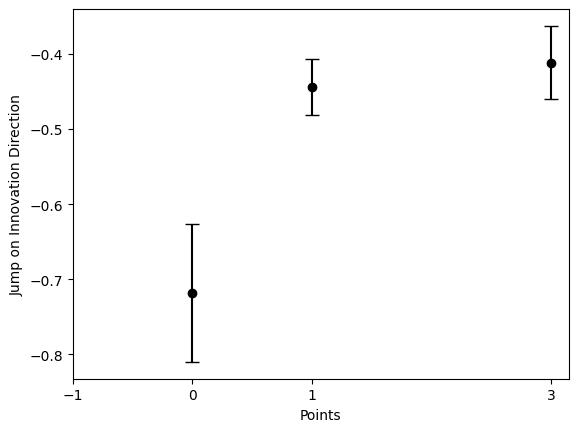

# Modulation of cos angel based on Reward

In [91]:
cosines = []
for subind, subdata in processed_forces.groupby('SubNum'):
    zone_two_data = subdata[subdata['zone'] == 2]
    for point, pointdata in zone_two_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute cosine similarity 
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                cosine_similarity = np.dot(force_vector_1, force_vector_2) / \
                (np.linalg.norm(force_vector_1) * np.linalg.norm(force_vector_2))
                # append to the cosines list
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })



    zone_three_data = subdata[subdata['zone'] == 3]
    for point, pointdata in zone_three_data.groupby('points'):
        # loop through all the points in the pointdata
        for i in range(len(pointdata)):
            row = pointdata.iloc[i]
            N = row['N']
            next_trial = subdata[subdata['N'] == N + 1]
            if not next_trial.empty:
                next_row = next_trial.iloc[0]
                # compute cosine similarity 
                force_vector_1 = row['force_vector']
                force_vector_2 = next_row['force_vector']
                cosine_similarity = np.dot(force_vector_1, force_vector_2) / \
                (np.linalg.norm(force_vector_1) * np.linalg.norm(force_vector_2))
                # append to the cosines list
                cosines.append({
                    'SubNum': subind,
                    'points': point,
                    'zone': row['zone'],
                    'cosine_similarity': cosine_similarity
                })
        

cosines = pd.DataFrame(cosines)
        
cosines['count'] = 1

In [96]:
grouped_cosines

SubNum  points  zone  cosine_similarity  count
0        1       0     3           0.574944     56
1        1       1     2           0.711609     73
2        1       1     3           0.685010     59
3        1       3     2           0.681425     80
4        2       0     3           0.715447     67
5        2       1     2           0.736030     85
6        2       1     3           0.759794     75
7        2       3     2           0.707810     77
8        3       0     3           0.419930     50
9        3       1     2           0.442977     78
10       3       1     3           0.344822     49
11       3       3     2           0.498511     88
12       4       0     3           0.617043     49
13       4       1     2           0.562838     62
14       4       1     3           0.587991     62
15       4       3     2           0.608121     70
16       5       0     3           0.412417     51
17       5       1     2           0.520383     96
18       5       1     3           0.389678     56
19       5       3     2           0.519711    101
20       6       0     3           0.193298     57
21       6       1     2           0.291219     65
22       6       1     3           0.133060     53
23       6       3     2           0.484554     76

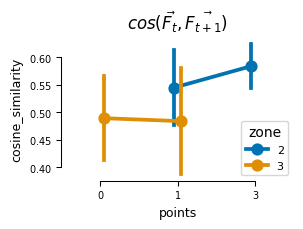

Zone: 2
TtestResult(statistic=-1.1468726500179014, pvalue=0.30333513477852625, df=5)
Zone: 3
TtestResult(statistic=0.19071975262627922, pvalue=0.8562472651645529, df=5)


In [ ]:
grouped_cosines = cosines.groupby(['SubNum', 'points', 'zone']).agg({'cosine_similarity': 'mean',
                                                                         'count': 'count'}).reset_index()
grouped_cosines

sns.pointplot(data=grouped_cosines, x='points', y='cosine_similarity', hue='zone', palette='colorblind', dodge=0.1, errorbar='se')
sns.despine(trim=True)
plt.title(r'$cos (\vec{F_t}, \vec{F_{t+1}})$')
plt.show()

for group_data in grouped_cosines.groupby('zone'):
    points = group_data[1]['points'].unique()
    print(f"Zone: {group_data[0]}")
    print(stats.ttest_rel(group_data[1][group_data[1]['points'] == points[0]]['cosine_similarity'],
                    group_data[1][group_data[1]['points'] == points[1]]['cosine_similarity']))
    

